In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# load the location dataset

data_path = "/content/location_data_v2.csv"

df_reader = pd.read_csv(data_path, chunksize=100000)

df_reader

In [4]:
# do sampling

all_samples = []

df_reader = pd.read_csv(data_path, chunksize=100000)

for df in df_reader:
    all_samples.append(df.sample(500))


sample_df = pd.concat(all_samples, axis=0)

In [5]:
# size of sample df

sample_df.shape

(3500, 2)

In [6]:
sample_df

,pickup_latitude,pickup_longitude
266,40.759693,-73.965897
57023,40.741154,-73.994057
3776,40.734707,-73.988235
16159,40.745770,-73.998146
97487,40.764538,-73.972870
...,...,...
600006,40.772758,-73.978523
601590,40.717068,-74.014420
600397,40.766586,-73.986916
601507,40.761585,-73.999710


Text(0, 0.5, 'Longitude')

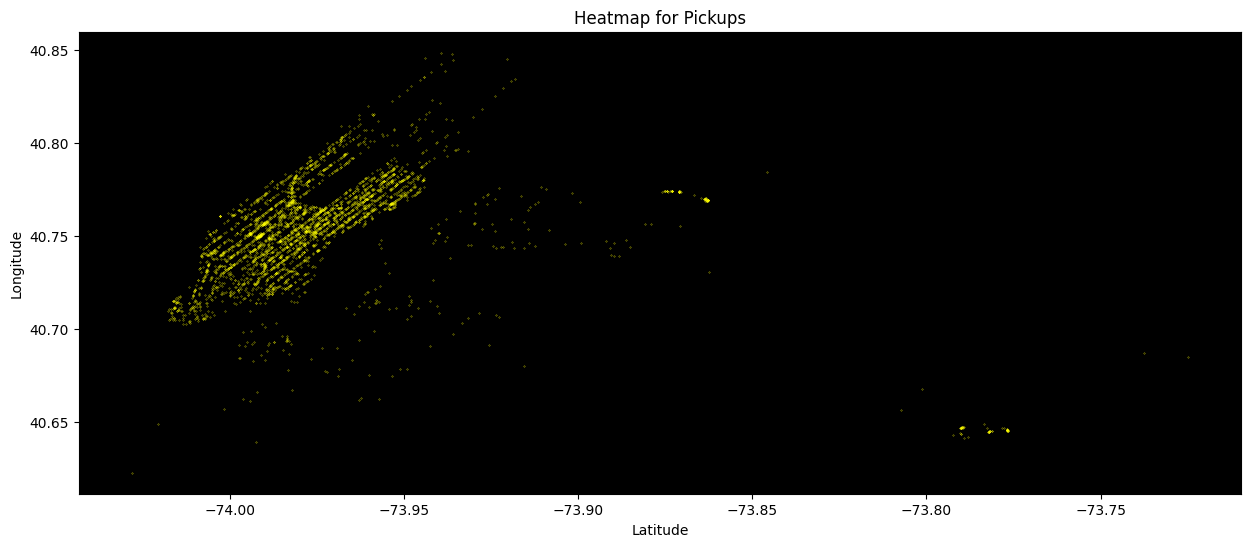

In [7]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(sample_df['pickup_longitude'],sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [8]:
from sklearn import set_config

set_config(transform_output='pandas')

In [9]:
# scale the input columns

from sklearn.preprocessing import StandardScaler

scale_samples = StandardScaler()

scaled_sample_df = scale_samples.fit_transform(sample_df)

In [10]:
scaled_sample_df

,pickup_latitude,pickup_longitude
266,0.273175,0.202015
57023,-0.390616,-0.591701
3776,-0.621440,-0.427625
16159,-0.225351,-0.706963
97487,0.446635,0.005468
...,...,...
600006,0.740970,-0.153877
601590,-1.252998,-1.165645
600397,0.519980,-0.390422
601507,0.340920,-0.751046


Text(0, 0.5, 'Longitude')

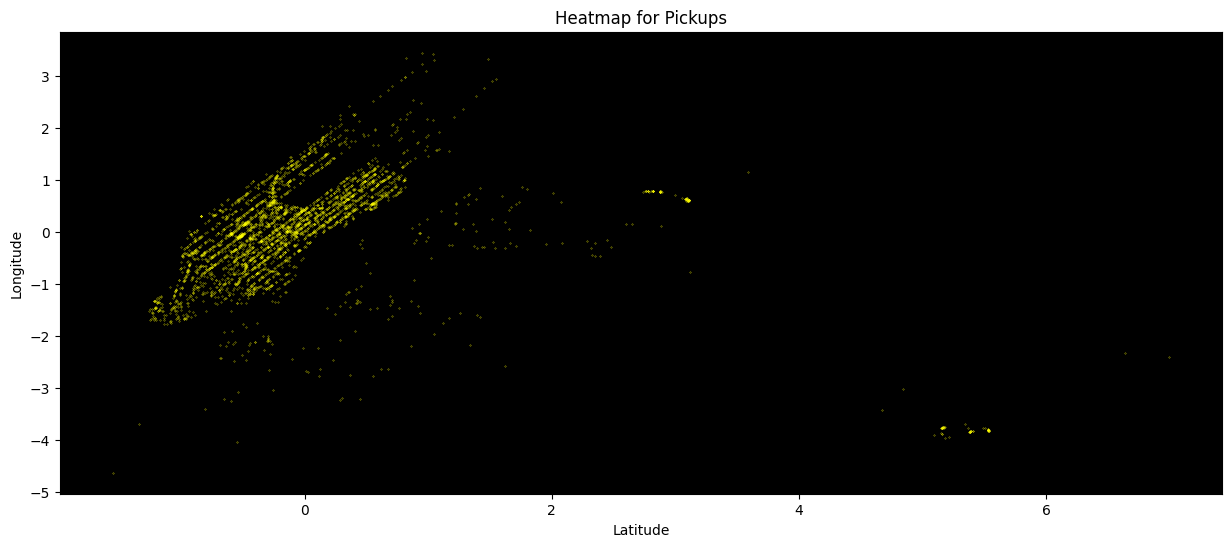

In [11]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],s=0.05,color='yellow')
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

In [12]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

In [13]:
df_reader = pd.read_csv(data_path, chunksize=100000)

In [14]:
# train the standard scaler

scaler = StandardScaler()

for chunk in df_reader:
    # fit the scaler
    scaler.partial_fit(chunk)

In [15]:
scaler

StandardScaler()

In [16]:
# get the scaler std and mean

print("The mean values are ", scaler.mean_)
print("The sigma values are ", scaler.scale_ )

The mean values are  [ 40.7511875  -73.97339711]
The sigma values are  [0.02809262 0.0352843 ]


In [17]:
def haversine_distance(lat1:float, lon1:float, lat2:float, lon2:float):
    """
    Calculate haversine distances between two points given their latitude and
    longitude coordinates
    """

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(
        dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))

    earth_radius = 3958.8
    distance = earth_radius * c
    return distance

In [18]:
def select_optimum_k(k_values):
    for k in k_values:
        df_reader = pd.read_csv(data_path, chunksize=100000)
        mini_batch = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)

        for chunk in df_reader:
            # scale the chunk
            scaled_chunk = scaler.transform(chunk)
            # train the model
            mini_batch.partial_fit(scaled_chunk)

        # centroid values
        centroids = scaler.inverse_transform(mini_batch.cluster_centers_)
        # calculate distances
        all_distances = []
        for i in centroids:
            distances = []
            for j in centroids:
                distance = haversine_distance(i[0], i[1], j[0], j[1])
                distances.append(distance)
            all_distances.append(distances)
        all_distances = np.array(all_distances)
        # sort array
        sorted_distances = np.sort(all_distances, axis=-1)
        # nearby regions
        region_count = 8
        # selected distances
        selected_distances = sorted_distances[:, 1:region_count+1]
        # average distances
        avg_distances = selected_distances.mean(axis=1)
        # count averages that fit criteria
        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()
        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()
        print(f"For {k} clusters, the number of nearby regions that fits criteria are {counter} and is {percentage * 100:.1f}% regions of total")

In [19]:
possible_k_values = np.arange(10,100,10)

possible_k_values

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [20]:
# select the optimum value of K

select_optimum_k(k_values=possible_k_values)

For 10 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total
For 20 clusters, the number of nearby regions that fits criteria are 0 and is 0.0% regions of total
For 30 clusters, the number of nearby regions that fits criteria are 10 and is 33.3% regions of total
For 40 clusters, the number of nearby regions that fits criteria are 8 and is 20.0% regions of total
For 50 clusters, the number of nearby regions that fits criteria are 10 and is 20.0% regions of total
For 60 clusters, the number of nearby regions that fits criteria are 11 and is 18.3% regions of total
For 70 clusters, the number of nearby regions that fits criteria are 11 and is 15.7% regions of total
For 80 clusters, the number of nearby regions that fits criteria are 17 and is 21.2% regions of total
For 90 clusters, the number of nearby regions that fits criteria are 15 and is 16.7% regions of total


In [21]:
df_reader = pd.read_csv(data_path, chunksize=100000)
mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)

# centroid values
centroids = mini_batch.cluster_centers_

centroids

array([[ 2.18822424,  0.58267054],
       [-1.07149785, -0.4074988 ],
       [-3.7502944 ,  5.37708842],
       [-0.03608214, -0.08118574],
       [ 0.61029214, -0.27164844],
       [ 0.49726784,  1.4680096 ],
       [-2.34757178, -0.38513107],
       [-0.40064567, -0.50411504],
       [ 1.03103389,  0.5869492 ],
       [-2.01768405,  1.53393282],
       [ 0.31074382,  0.10633377],
       [-1.44481599, -1.04361188],
       [ 0.63538512,  2.91735395],
       [ 0.28822109, -0.46008105],
       [ 1.57500788,  0.13092839],
       [-2.66904504,  0.48613286],
       [ 0.66681462,  0.41461572],
       [-0.71210411, -0.37434512],
       [-0.17476974,  1.43175703],
       [-1.2058318 ,  3.9145636 ],
       [-0.45496649, -0.85619019],
       [ 3.00911785,  1.1531232 ],
       [ 1.11276392, -0.13458443],
       [-3.97405026, -0.51089377],
       [-1.60777359,  0.87891858],
       [-0.04009215, -0.63392365],
       [-1.20439131,  0.49026426],
       [-0.18568025, -0.31814475],
       [-0.92116767,

In [22]:
centroids = scaler.inverse_transform(mini_batch.cluster_centers_)

centroids.shape

centroids

array([[ 40.81266045, -73.95283799],
       [ 40.72108632, -73.98777542],
       [ 40.64583192, -73.78367031],
       [ 40.75017386, -73.97626169],
       [ 40.76833221, -73.98298204],
       [ 40.76515706, -73.92159942],
       [ 40.68523807, -73.98698619],
       [ 40.73993232, -73.99118446],
       [ 40.78015194, -73.95268702],
       [ 40.69450548, -73.91927337],
       [ 40.75991711, -73.9696452 ],
       [ 40.71059884, -74.01022022],
       [ 40.76903713, -73.87046032],
       [ 40.75928439, -73.98963075],
       [ 40.7954336 , -73.96877739],
       [ 40.67620704, -73.95624425],
       [ 40.76992007, -73.95876769],
       [ 40.73118264, -73.98660562],
       [ 40.74627776, -73.92287857],
       [ 40.71731253, -73.83527448],
       [ 40.7384063 , -74.00360718],
       [ 40.8357215 , -73.93270997],
       [ 40.78244795, -73.97814583],
       [ 40.63954603, -73.99142364],
       [ 40.70602094, -73.94238508],
       [ 40.75006121, -73.99576466],
       [ 40.717353  , -73.95609848],
 

In [23]:
# calculate distances
all_distances = []
for i in centroids:
    distances = []
    for j in centroids:
        distance = haversine_distance(i[0], i[1], j[0], j[1])
        distances.append(distance)
    all_distances.append(distances)
all_distances = np.array(all_distances)

In [24]:
all_distances.shape

(30, 30)

In [25]:
# sort array
sorted_distances = np.sort(all_distances, axis=-1)

sorted_distances

array([[ 0.        ,  1.20343661,  1.45317261,  1.90955284,  2.2461596 ,
         2.47183804,  2.9693536 ,  3.44490985,  3.66652116,  3.74882464,
         4.16005087,  4.4880112 ,  4.84709818,  4.87355894,  4.89873292,
         5.25876898,  5.41082737,  5.77743433,  5.90040851,  6.56725463,
         6.5860794 ,  6.58739201,  7.38844143,  7.66465527,  8.35069474,
         8.98375041,  9.01398132,  9.42981044, 12.13062342, 14.53701014],
       [ 0.        ,  0.70027951,  0.81521045,  1.31432339,  1.38084482,
         1.4557643 ,  1.67877774,  1.72730741,  2.04522144,  2.0982295 ,
         2.47724774,  2.59509526,  2.64104722,  2.84591278,  3.27404085,
         3.51336189,  3.70005898,  3.81763009,  4.03063532,  4.2695814 ,
         4.47531525,  4.61227201,  5.2322991 ,  5.63719477,  5.79251454,
         6.5860794 ,  6.9778211 ,  7.99034837,  8.42832707, 11.89126835],
       [ 0.        ,  5.63060681,  7.8620192 ,  9.28545165,  9.29868648,
         9.6504425 , 10.06714528, 10.29789136, 10

In [26]:
# nearby regions
region_count = 8
# selected distances
selected_distances = sorted_distances[:, 1:region_count+1]
# average distances
avg_distances = selected_distances.mean(axis=1)

In [27]:
selected_distances

array([[ 1.20343661,  1.45317261,  1.90955284,  2.2461596 ,  2.47183804,
         2.9693536 ,  3.44490985,  3.66652116],
       [ 0.70027951,  0.81521045,  1.31432339,  1.38084482,  1.4557643 ,
         1.67877774,  1.72730741,  2.04522144],
       [ 5.63060681,  7.8620192 ,  9.28545165,  9.29868648,  9.6504425 ,
        10.06714528, 10.29789136, 10.90067129],
       [ 0.52522017,  0.75705023,  0.94120776,  1.02087702,  1.05402   ,
         1.30300095,  1.41952605,  1.64307102],
       [ 0.71545645,  0.90840108,  1.00760671,  1.2718344 ,  1.30300095,
         1.42872296,  1.54739356,  1.78316978],
       [ 1.30616465,  1.92859477,  1.97264045,  2.46425655,  2.5403308 ,
         2.68949418,  3.04242199,  3.19086015],
       [ 1.72744574,  2.13349701,  2.47724774,  2.74246908,  2.74617944,
         2.88272227,  3.16560513,  3.17456082],
       [ 0.54045993,  0.65034588,  0.65884359,  0.73977739,  1.05402   ,
         1.16629168,  1.31432339,  1.33958471],
       [ 0.77525629,  1.31744706

In [28]:
avg_distances

array([2.42061804, 1.38971613, 9.12411432, 1.08299665, 1.24569824,
       2.39184544, 2.6312159 , 0.93295582, 1.54978581, 3.31097693,
       1.20652277, 2.04057157, 4.19594924, 1.13002554, 1.78433389,
       2.94072036, 1.43809386, 1.1232443 , 2.60163401, 5.48295487,
       1.16663578, 3.91615561, 1.55323811, 4.90049904, 2.41267458,
       1.04649432, 2.1207976 , 0.95122403, 1.31787078, 2.03609631])

In [29]:
((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()

np.float64(0.3333333333333333)

# Clustering

In [30]:
df_reader = pd.read_csv(data_path, chunksize=100000)

In [31]:
# train the model

mini_batch = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in df_reader:
    # scale the chunk
    scaled_chunk = scaler.transform(chunk)
    # train the model
    mini_batch.partial_fit(scaled_chunk)

In [32]:
mini_batch

MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

In [33]:
# centroids of the model

mini_batch.cluster_centers_

array([[ 2.18822424,  0.58267054],
       [-1.07149785, -0.4074988 ],
       [-3.7502944 ,  5.37708842],
       [-0.03608214, -0.08118574],
       [ 0.61029214, -0.27164844],
       [ 0.49726784,  1.4680096 ],
       [-2.34757178, -0.38513107],
       [-0.40064567, -0.50411504],
       [ 1.03103389,  0.5869492 ],
       [-2.01768405,  1.53393282],
       [ 0.31074382,  0.10633377],
       [-1.44481599, -1.04361188],
       [ 0.63538512,  2.91735395],
       [ 0.28822109, -0.46008105],
       [ 1.57500788,  0.13092839],
       [-2.66904504,  0.48613286],
       [ 0.66681462,  0.41461572],
       [-0.71210411, -0.37434512],
       [-0.17476974,  1.43175703],
       [-1.2058318 ,  3.9145636 ],
       [-0.45496649, -0.85619019],
       [ 3.00911785,  1.1531232 ],
       [ 1.11276392, -0.13458443],
       [-3.97405026, -0.51089377],
       [-1.60777359,  0.87891858],
       [-0.04009215, -0.63392365],
       [-1.20439131,  0.49026426],
       [-0.18568025, -0.31814475],
       [-0.92116767,

In [34]:
scaler.inverse_transform(mini_batch.cluster_centers_)

array([[ 40.81266045, -73.95283799],
       [ 40.72108632, -73.98777542],
       [ 40.64583192, -73.78367031],
       [ 40.75017386, -73.97626169],
       [ 40.76833221, -73.98298204],
       [ 40.76515706, -73.92159942],
       [ 40.68523807, -73.98698619],
       [ 40.73993232, -73.99118446],
       [ 40.78015194, -73.95268702],
       [ 40.69450548, -73.91927337],
       [ 40.75991711, -73.9696452 ],
       [ 40.71059884, -74.01022022],
       [ 40.76903713, -73.87046032],
       [ 40.75928439, -73.98963075],
       [ 40.7954336 , -73.96877739],
       [ 40.67620704, -73.95624425],
       [ 40.76992007, -73.95876769],
       [ 40.73118264, -73.98660562],
       [ 40.74627776, -73.92287857],
       [ 40.71731253, -73.83527448],
       [ 40.7384063 , -74.00360718],
       [ 40.8357215 , -73.93270997],
       [ 40.78244795, -73.97814583],
       [ 40.63954603, -73.99142364],
       [ 40.70602094, -73.94238508],
       [ 40.75006121, -73.99576466],
       [ 40.717353  , -73.95609848],
 

In [35]:
# perform predictions and assign clusters

sample_predictions = mini_batch.predict(scaled_sample_df)

sample_predictions.shape

(3500,)

In [36]:
np.unique(sample_predictions)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

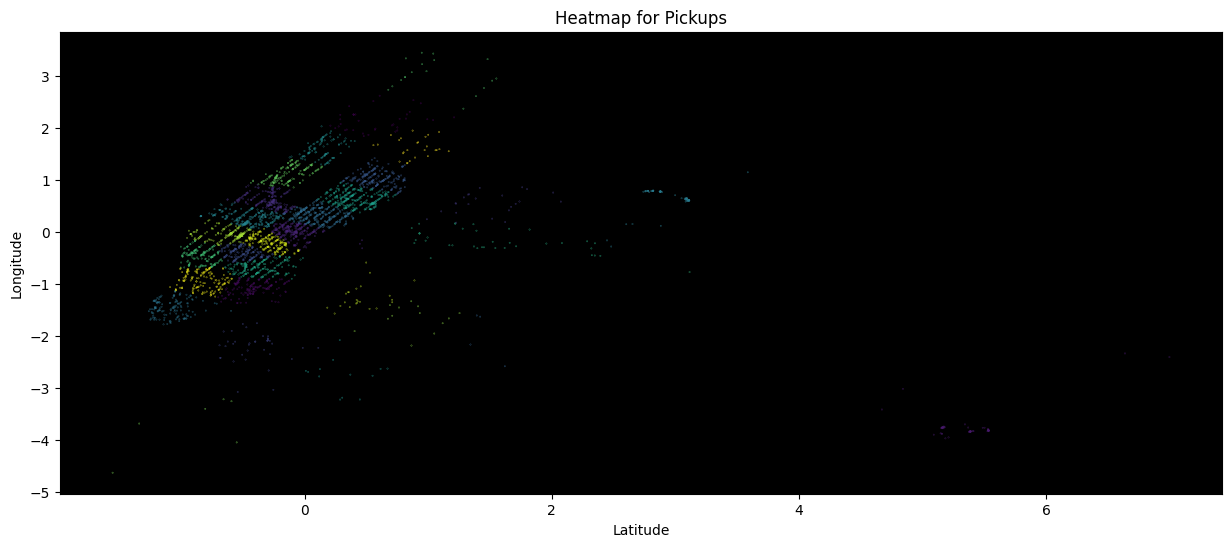

In [37]:
# plot the dataset on a scatterplot

fig,ax = plt.subplots(nrows=1,ncols=1,sharey=True,
                     figsize=(15,6))

ax.set_facecolor('k')
ax.scatter(scaled_sample_df['pickup_longitude'],scaled_sample_df['pickup_latitude'],
           s=0.05,c=sample_predictions)
ax.set_title('Heatmap for Pickups')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

plt.show()